In [1]:
import gpxpy
import mplleaflet
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

import matplotlib.pyplot as plt
#plt.rcParams['axes.xmargin'] = 0.1
#plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

from gps_utils import haversine

%load_ext autoreload
%autoreload 2

In [2]:
from kalman_steps import *

In [3]:
gpx_obj, segment = step_01_load_data(1)

/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/hh_marathon.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/activity_11212422262.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/3-laender-giro_cleaned.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/3-laender-giro.gpx


### Let's try to correct some unrealistic things like

In [4]:
segment.get_uphill_downhill()

UphillDownhill(uphill=231.82000389099125, downhill=232.42000999450704)

### ... and speed records on a bikecycle

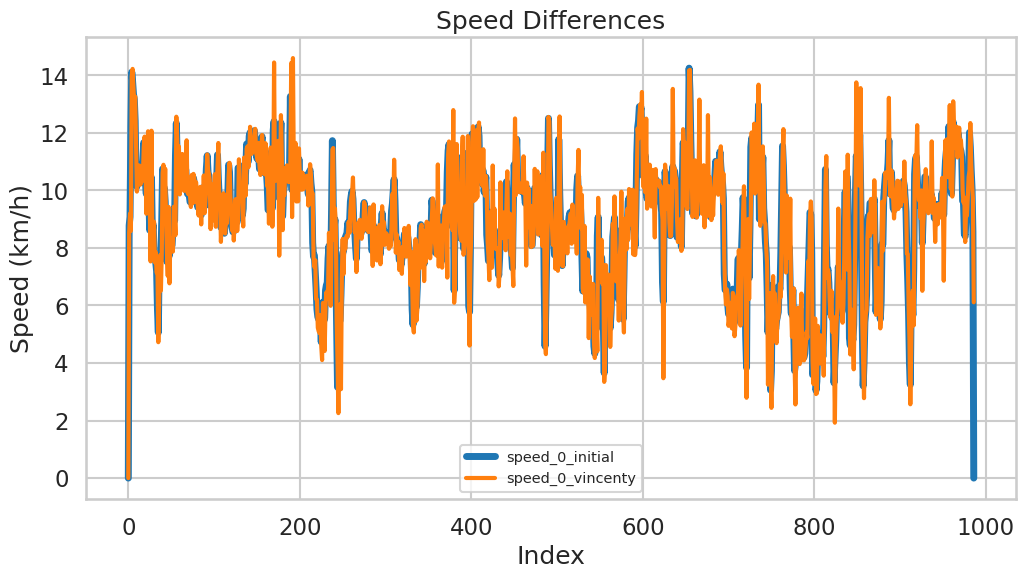

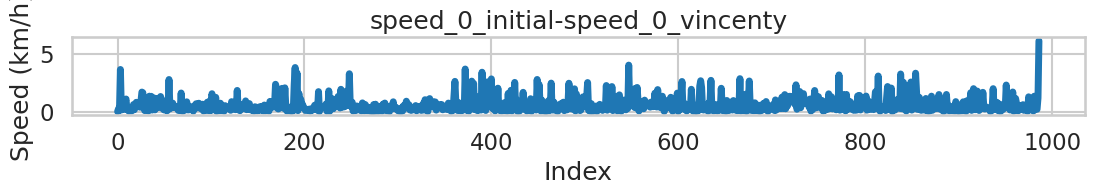

In [5]:
speed_dict = {}
step_02_initial_speed(gpx_obj, segment, speed_dict)
plot_all_keys(speed_dict)
plot_all_key_difs(speed_dict)

### But we start with a little bit of data wrangling

In [6]:
coords = step_03_segments_to_coords_pd(segment)
print(coords.head())
print(coords.tail())

                           idx        lat        lon         ele     speed
time                                                                      
2023-05-28 03:34:21+00:00    0  41.138656  29.028546  109.800003  0.000000
2023-05-28 03:34:27+00:00    1  41.138534  29.028598  109.400002  2.439495
2023-05-28 03:34:30+00:00    2  41.138471  29.028636  108.800003  2.522874
2023-05-28 03:34:31+00:00    3  41.138453  29.028650  108.800003  3.398323
2023-05-28 03:34:33+00:00    4  41.138388  29.028685  108.199997  3.920986
                           idx        lat        lon         ele     speed
time                                                                      
2023-05-28 04:34:09+00:00  982  41.138998  29.029168  111.199997  3.195113
2023-05-28 04:34:15+00:00  983  41.138993  29.028951  110.000000  2.974100
2023-05-28 04:34:18+00:00  984  41.138994  29.028849  109.800003  2.793329
2023-05-28 04:34:20+00:00  985  41.138981  29.028787  109.199997  2.376304
2023-05-28 04:34:21+00:00

### Oh... time interval is not always 1sec, let's do something about that and round to nearest sec

In [7]:
step_04_round_time(coords)
coords.tail()

,idx,lat,lon,ele,speed
time,,,,,
2023-05-28 04:34:09,982,41.138998,29.029168,111.199997,3.195113
2023-05-28 04:34:15,983,41.138993,29.028951,110.000000,2.974100
2023-05-28 04:34:18,984,41.138994,29.028849,109.800003,2.793329
2023-05-28 04:34:20,985,41.138981,29.028787,109.199997,2.376304
2023-05-28 04:34:21,986,41.138976,29.028768,109.199997,0.000000


### Do we have signal loss?

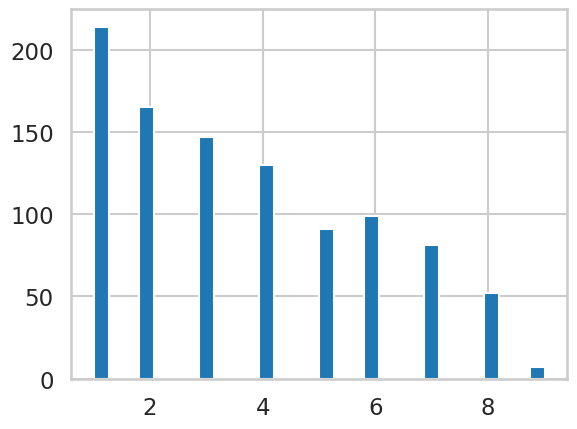

In [8]:
plt.hist(np.abs(np.diff(coords.index).astype('timedelta64[s]').astype(float)), bins=30);

### Okay, let's resample with 1 sec intevals and fill up with NaN

In [9]:
coords = step_05_resample(coords=coords, freq='1s')

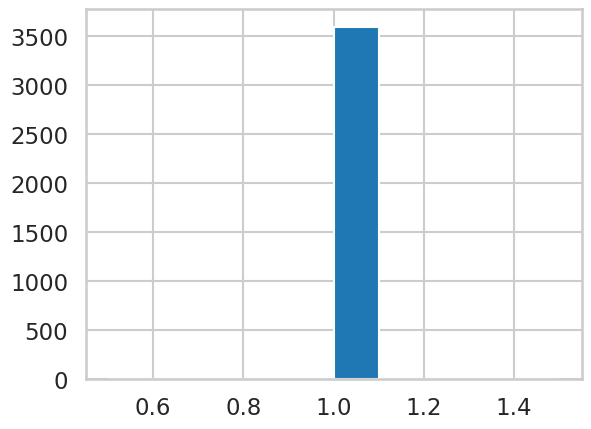

In [10]:
coords.loc[coords.ele.isnull()].head()
plt.hist(np.diff(coords.index).astype('timedelta64[s]').astype(float));

### Almost done. Now convert to good old numpy array and mask NaNs

In [11]:
measurements = step_06_get_measurements_from_coords(coords) # lon-0 lat-1 ele-2

### So where did I lose the GPS signal?

num of filled coords=2614 in 3601


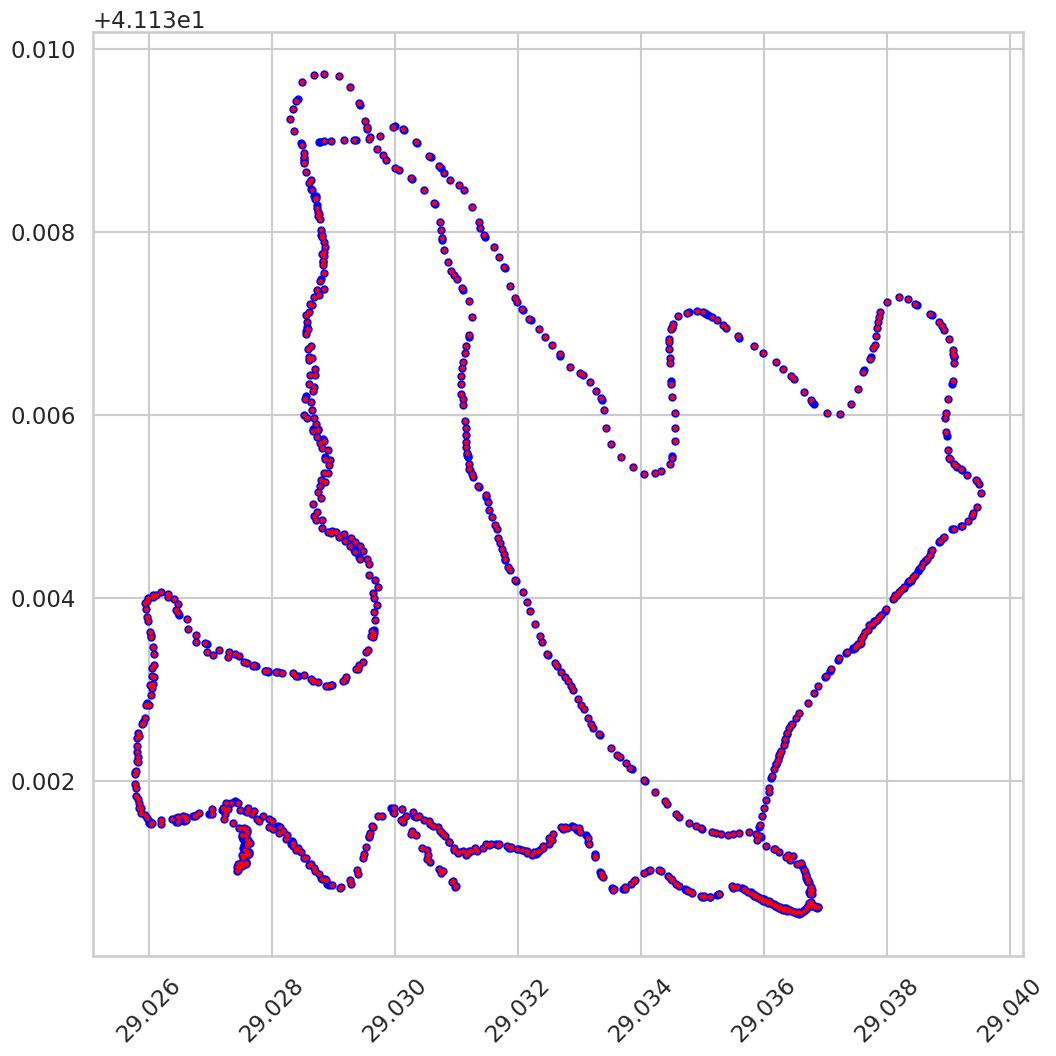

In [12]:
coords, original_coords_idx = step_07_fill_nan_values(coords, measurements, 2)

### Let's set up the Kalman Filter

In [13]:
kf, kf_dict = step_08_setup_kalman_filter(measurements)

### Compare now our measurements with a smoothed track

In [14]:
state_means, state_vars = step_09_apply_kalman(kf, measurements)

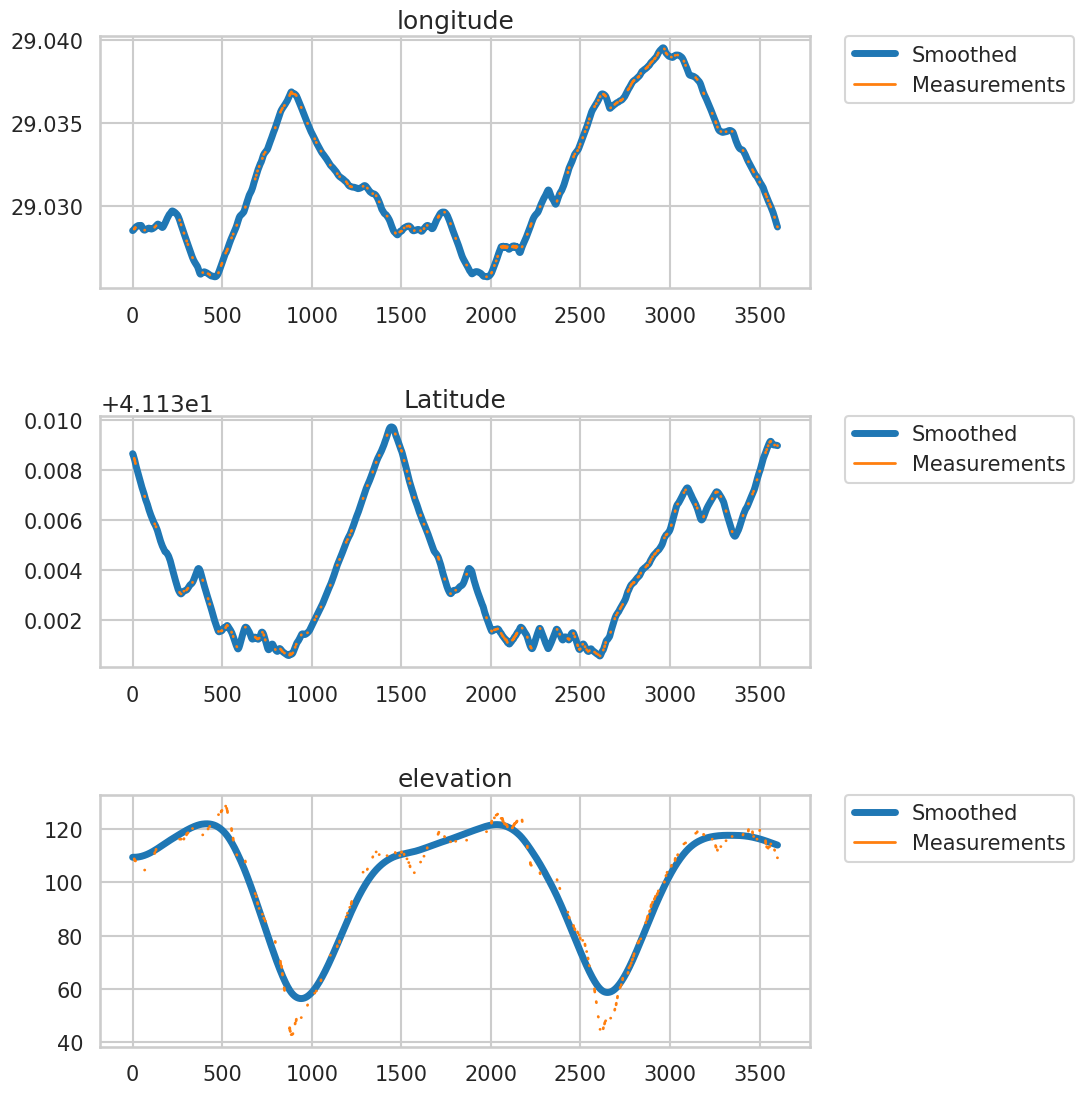

In [15]:
step_10_plot_smoothed_vs_measured(state_means, measurements)

### Let's write the smoothed data back into our dataframe and GPX file

In [16]:
coords, orig_coords = step_11_15_update_coords(state_means, coords, segment, original_coords_idx)

In [17]:
segment.get_uphill_downhill()

UphillDownhill(uphill=136.87978053118067, downhill=132.31327302003876)

### Yes, that sounds much more realistic!!! Let's also check the speed

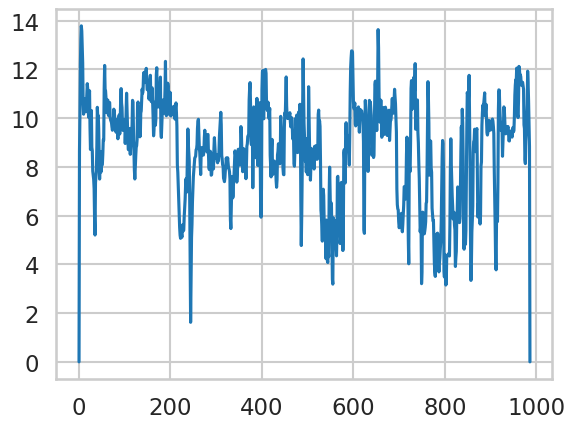

In [18]:
speed = step_12_16_add_missing_speeds(gpx_obj, segment, speed_dict, 'speed_1_after_kalman', plot_afeter_add=True)

### Arrrggh!!! Still not good! What the heck is going on?

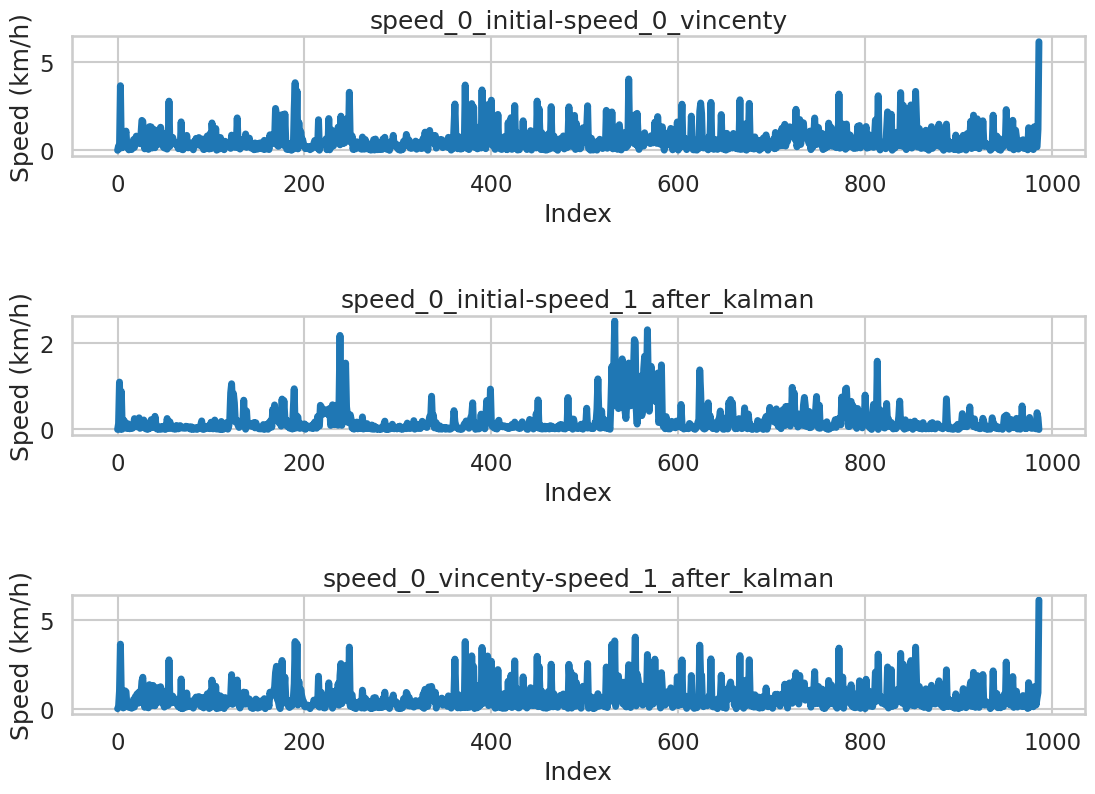

In [19]:
plot_all_key_difs(speed_dict)

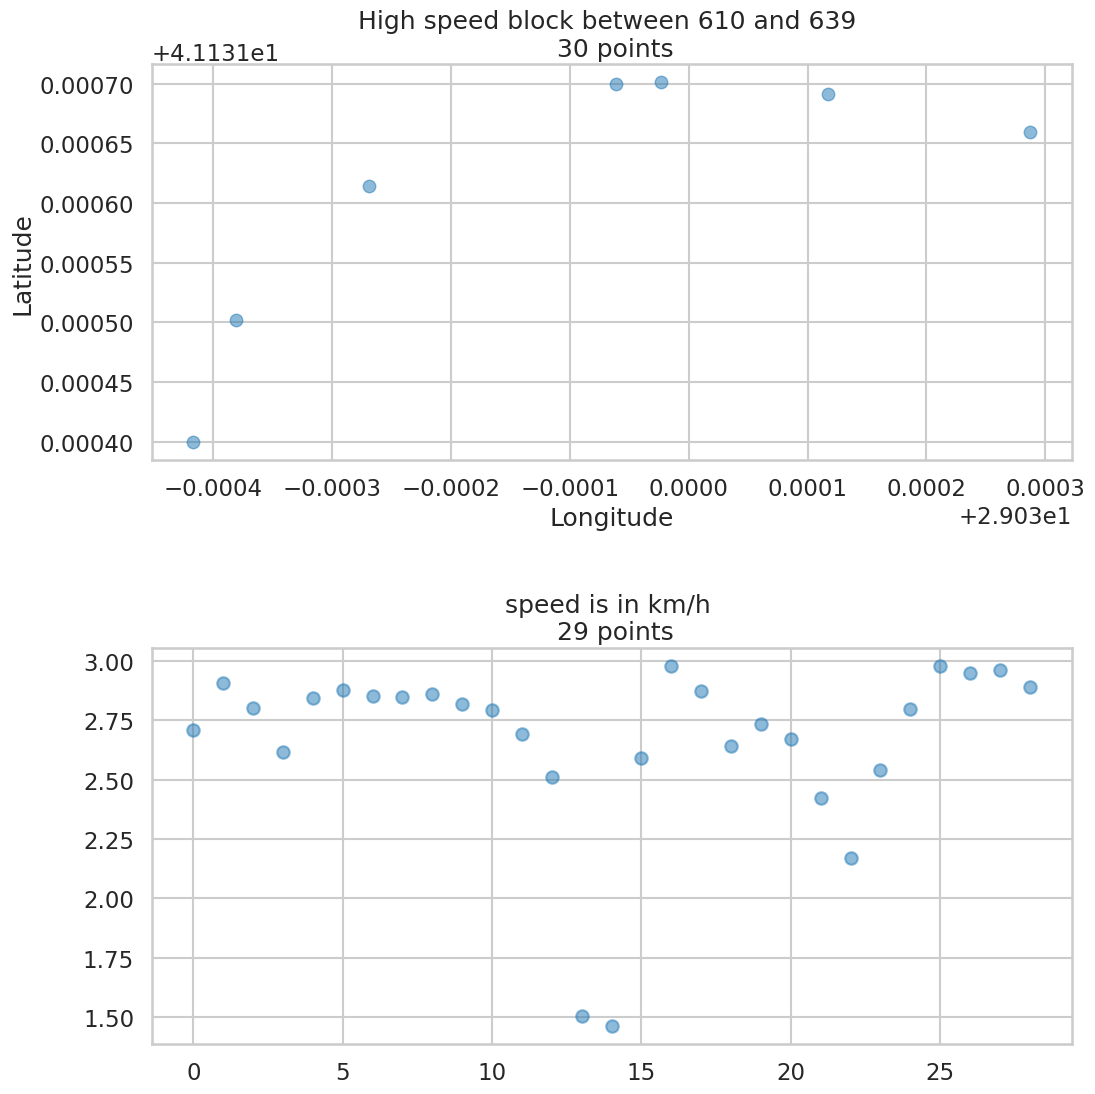

In [20]:
use_sub_arr = step_13_get_high_speed_block(speed, measurements, segment, plot_result=True, verbose=False)

### Here we have one of the hyperspeed points, so what happens here? Points seem to stack...

### Looking at these numbers the sensors seems to be quite inert! Let's just eliminate unlikely points and their surroundings by using the covariance given by the Kalman filter!

In [21]:
measurements, bad_readings = step_14_find_bad_readings_from_variance(measurements, state_vars, verbose=True)

there are 3601 of mask vars.
number of true elements in the mask(shape=(3601, 3) with 10803 elements) are 7842
there are 89 bad readings
bad readings where the mask was false count is: 67


In [22]:
state_means, state_vars = kf.smooth(measurements)

### Write it back our GPX file again

In [23]:
coords, orig_coords = step_11_15_update_coords(state_means, coords, segment, original_coords_idx)

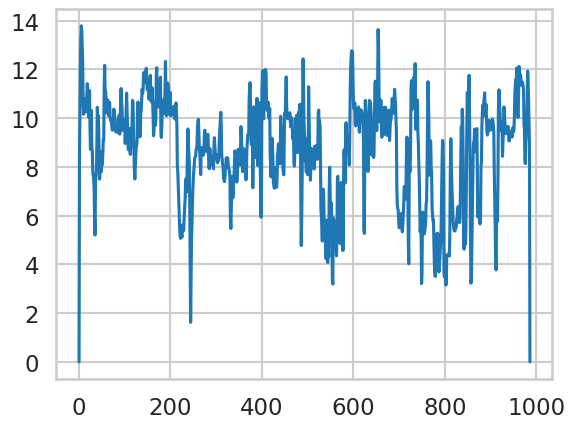

In [24]:
speed = step_12_16_add_missing_speeds(gpx_obj, segment, speed_dict, 'speed_2_add_missing', plot_afeter_add=True)

### We are getting there! Let's take a look where the problem is...

there are 3601 of mask vars.
number of true elements in the mask(shape=(3601, 3) with 10803 elements) are 7908
number of masked elements=2636 unmasked=965


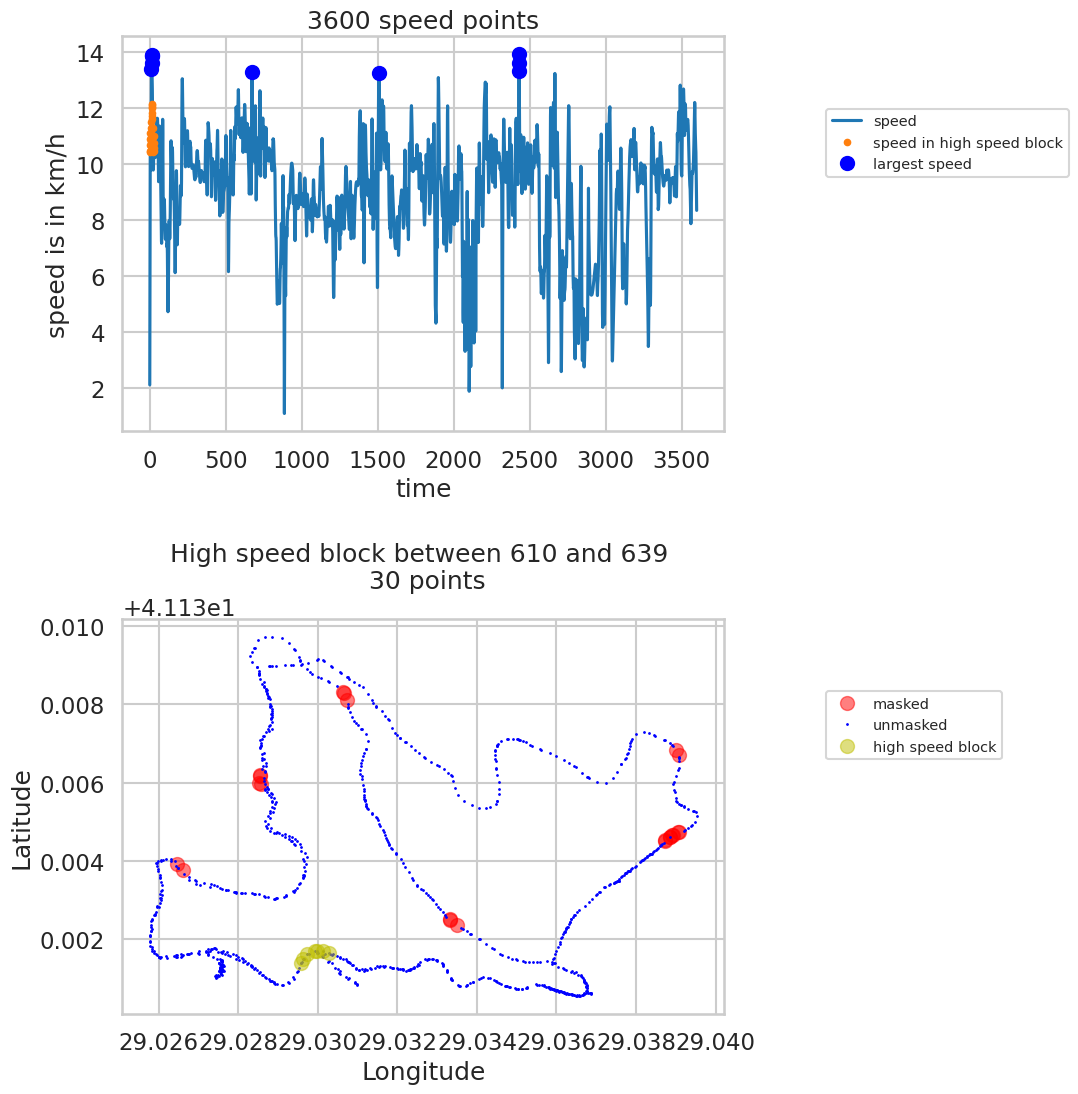

In [25]:
step_17_21_calc_speed_with_corrected_positions(state_means, speed_dict, "speed_3_after_calc", measurements, use_sub_arr, verbose=False, plot_result=2)

### mmhhh.. okay, that's hard. The GPS sensor has fallen behind in a curve, followed by "normal" readings then has caught up with the actual position

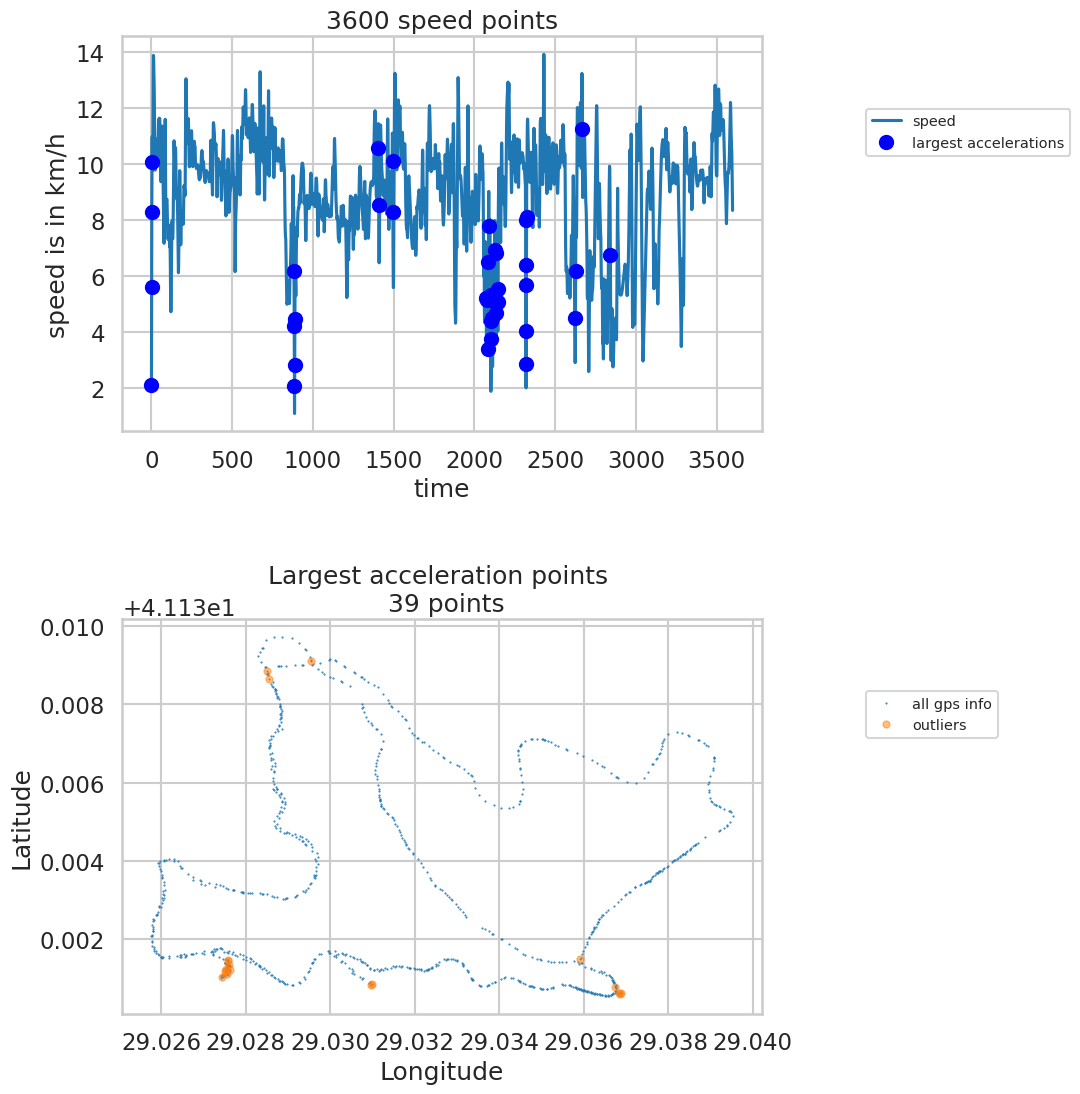

In [26]:
outliers_idx = step_18_check_for_outliers_by_strong_accelerations(speed_dict["speed_3_after_calc"], measurements, plot_result=True)

### Okay, let's just remove those points with surroundings and let Kalman do the rest

In [27]:
state_means, state_vars, measurements = step_19_mask_around_outliers(kf, measurements, outliers_idx, neighbour_cnt=12)

In [28]:
state_means, state_vars = step_20_apply_kalman(state_means, state_vars, kf, n_times=20)

Iterations in sec:<0:1.04><1:1.04><2:1.05><3:1.05><4:1.00><5:1.04><6:1.03><7:1.12><8:1.10><9:1.08><10:1.10><11:1.09><12:1.50><13:2.40><14:1.36><15:1.70><16:1.77><17:1.73><18:1.82><19:1.74>

Durations: min(1.0017180442810059), mean(1.3387529611587525), max(2.4006190299987793)


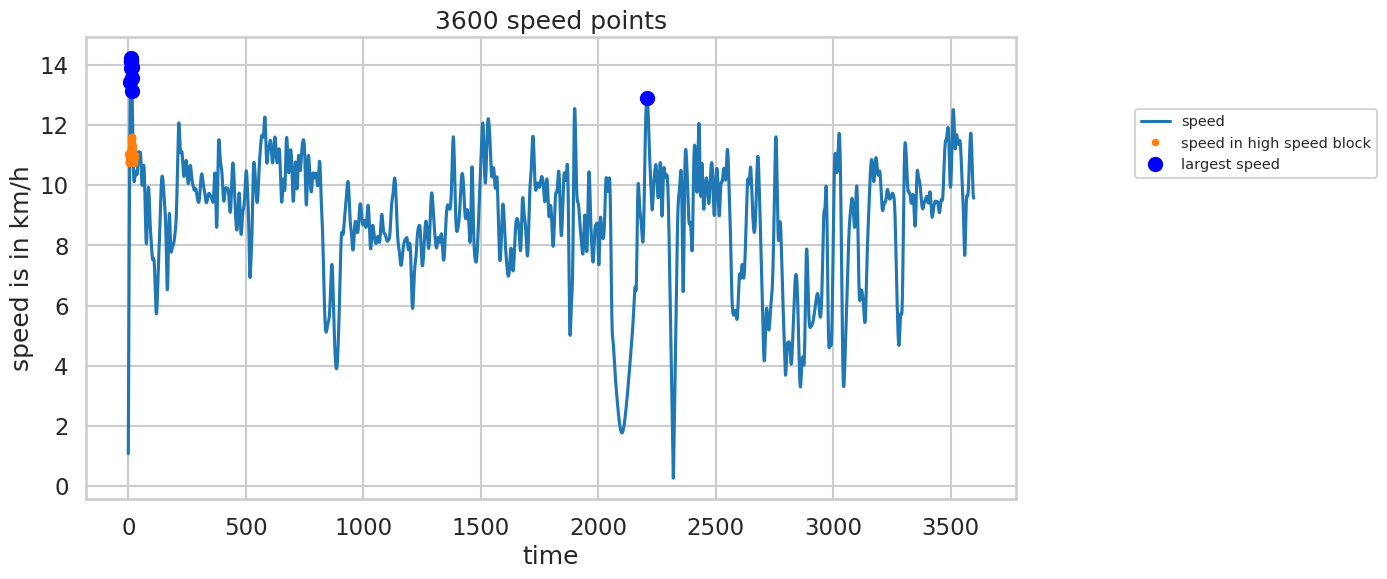

In [29]:
step_17_21_calc_speed_with_corrected_positions(state_means, speed_dict, "speed_4_after_calc20", measurements, use_sub_arr, verbose=False, plot_result=1)

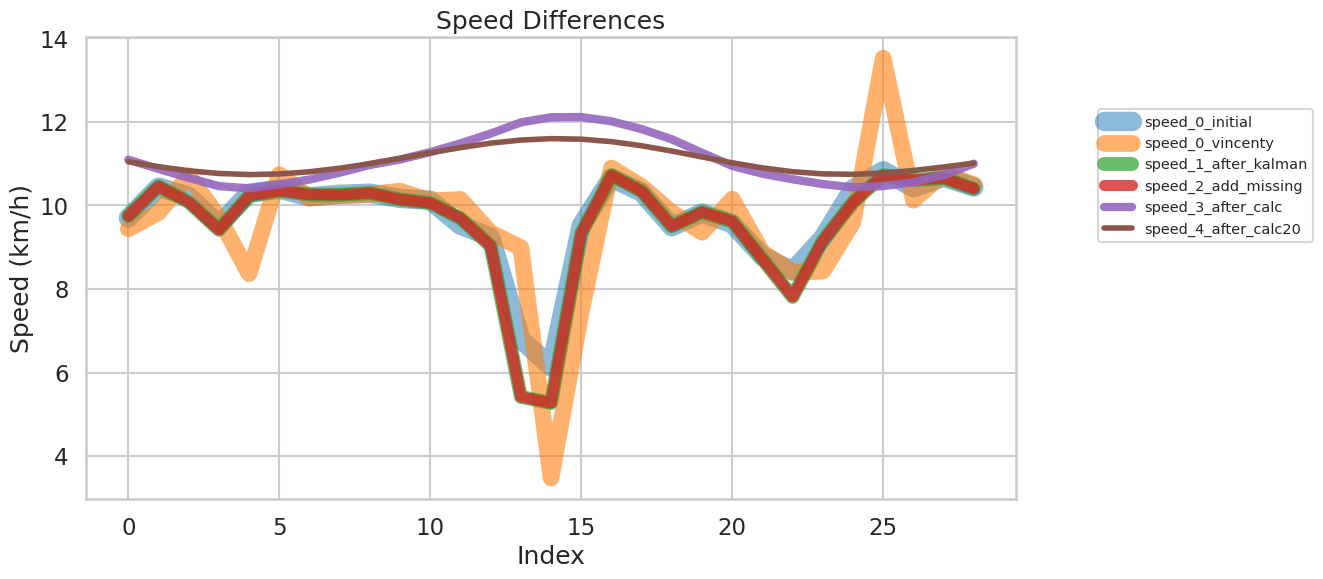

In [38]:
plot_all_keys(speed_dict,fr_to=[min(use_sub_arr),max(use_sub_arr)])
#plt.plot(speed_dict["speed_4_after_calc20"][min(use_sub_arr):max(use_sub_arr)], '.')

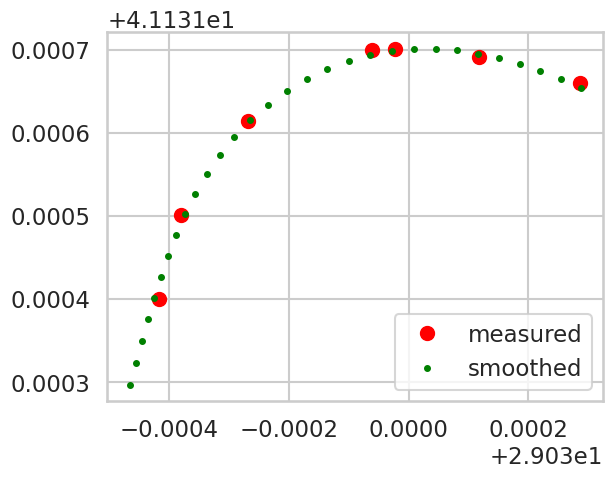

In [44]:
plt.plot(measurements[use_sub_arr,0], measurements[use_sub_arr,1], 'ro', label='measured', markersize=10)
plt.plot(state_means[use_sub_arr,0], state_means[use_sub_arr,1], 'g.',label='smoothed', markersize=8)
plt.legend()
plt.show()

In [ ]:
coords.iloc[:, [2,1,3]] = state_means[:,:3]
orig_coords = coords[~coords['idx'].isnull()].set_index('idx')

In [ ]:
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']

In [ ]:
segment.get_uphill_downhill()

### Finally, write everything back to the GPX file

In [ ]:
coords.iloc[:, [2,1,3]] = state_means[:,:3]
orig_coords = coords[~coords['idx'].isnull()].set_index('idx')
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()
speed = np.array([p.speed for p in segment.points])*3.6
speed_dict['speed_5_after_final'] = speed
plt.plot(speed)

In [ ]:
fig, axs = plt.subplots(figsize=(12, 6))
thickness = 15
for key, arr in speed_dict.items():
    print(f"key: {key}, len: {len(arr)}")
    plt.plot(arr[0:300], label=key, linewidth=thickness)
    thickness -= 2

plt.legend(loc='lower center', fontsize='xx-small')
plt.title("Speed Differences")
plt.show()

In [ ]:
#with open('../gpx/3-laender-giro_cleaned.gpx', 'w') as fh:
#    fh.write(gpx_file.to_xml())